## 1. Load & Convert Recordings
Read all `.m4a` recordings from disk and convert to `.wav`.

In [ ]:
import os
import re
from pydub import AudioSegment

RECORDINGS_DIR = "Recordings"
WAV_DIR = "wav"
os.makedirs(WAV_DIR, exist_ok=True)

recordings = {}
for fname in sorted(os.listdir(RECORDINGS_DIR), key=lambda x: int(re.search(r'\d+', x).group())):
    match = re.match(r's_(\d+)_(g|b)\.m4a', fname)
    if match:
        num = int(match.group(1))
        label = match.group(2)
        m4a_path = os.path.join(RECORDINGS_DIR, fname)
        wav_path = os.path.join(WAV_DIR, f"s_{num}_{label}.wav")
        AudioSegment.from_file(m4a_path, format="m4a").export(wav_path, format="wav")
        recordings[num] = {"label": label, "wav_path": wav_path}

print(f"Converted {len(recordings)} files")
print(f"  Good: {sum(1 for v in recordings.values() if v['label'] == 'g')}")
print(f"  Bad:  {sum(1 for v in recordings.values() if v['label'] == 'b')}")


Converted 27 files
  Good: 19
  Bad:  8


## 2. Noise Reduction
Apply spectral gating (`noisereduce`) followed by a bandpass filter (200 Hz – 20 kHz) to clean each recording.

Denoised 27 recordings


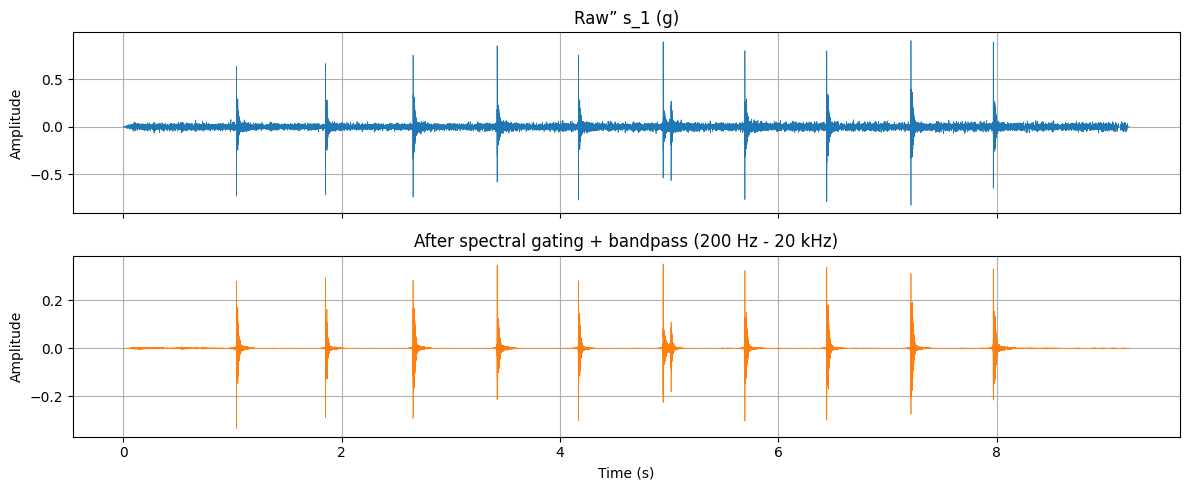

In [ ]:
import librosa
import numpy as np
import noisereduce as nr
from scipy.signal import butter, sosfilt
import matplotlib.pyplot as plt

SR = 48000
NOISE_SAMPLE_DURATION = 0.5  # seconds assumes recording starts with silence before first tap

def bandpass_filter(audio, sr, low_hz=200, high_hz=20000, order=5):
    sos = butter(order, [low_hz, high_hz], btype='bandpass', fs=sr, output='sos')
    return sosfilt(sos, audio)

for num, info in recordings.items():
    audio, _ = librosa.load(info['wav_path'], sr=SR, mono=True)
    noise_sample = audio[:int(NOISE_SAMPLE_DURATION * SR)]

    # Step 1: spectral gating (Adobe Audition-style noise reduction)
    audio_nr = nr.reduce_noise(y=audio, sr=SR, y_noise=noise_sample)

    # Step 2: bandpass filter to keep only tap-response frequencies
    audio_clean = bandpass_filter(audio_nr, SR)

    recordings[num]['audio'] = audio_clean

print(f"Denoised {len(recordings)} recordings")

# --- Before/after comparison on first recording ---
sample_num = next(iter(recordings))
raw, _ = librosa.load(recordings[sample_num]['wav_path'], sr=SR, mono=True)
clean = recordings[sample_num]['audio']
t = np.arange(len(raw)) / SR

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(t, raw, linewidth=0.5)
ax[0].set_title(f"Raw” s_{sample_num} ({recordings[sample_num]['label']})")
ax[0].set_ylabel("Amplitude")
ax[0].grid()
ax[1].plot(t, clean, linewidth=0.5, color='tab:orange')
ax[1].set_title("After spectral gating + bandpass (200 Hz - 20 kHz)")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()
plt.tight_layout()
plt.show()


## 3. Splice Individual Taps
Detect individual impact events using peak detection and extract a fixed-length window around each tap.

In [ ]:
from scipy.signal import find_peaks

def splice_audio(audio, sr, pre_peak=100, post_peak=3000):
    # Use relative threshold: 30% of the signal peak, robust across recordings
    threshold = 0.3 * np.max(np.abs(audio))
    peaks, _ = find_peaks(audio, height=threshold, distance=30000)
    # Guard against peaks too close to the edges
    valid = [p for p in peaks if p >= pre_peak and p + post_peak <= len(audio)]
    splices = np.array([audio[p - pre_peak : p + post_peak] for p in valid])
    return splices

healthy_hits = []
unhealthy_hits = []

for num, info in recordings.items():
    splices = splice_audio(info['audio'], SR)
    if splices.size == 0:
        print(f"  WARNING: no peaks found in s_{num} ({info['label']})")
        continue
    if info['label'] == 'g':
        healthy_hits.append(splices)
    else:
        unhealthy_hits.append(splices)

healthy_hits = np.concatenate(healthy_hits, axis=0)
unhealthy_hits = np.concatenate(unhealthy_hits, axis=0)

print(f"Healthy hits:   {healthy_hits.shape}  ({healthy_hits.shape[0]} splices)")
print(f"Unhealthy hits: {unhealthy_hits.shape}  ({unhealthy_hits.shape[0]} splices)")
print(f"Splice length:  {healthy_hits.shape[1]} samples = {healthy_hits.shape[1]/SR*1000:.1f} ms")


Healthy hits:   (149, 3100)  (149 splices)
Unhealthy hits: (128, 3100)  (128 splices)
Splice length:  3100 samples = 64.6 ms


## 4. Train / Test Split & Average PSD
Split splices 70/30 into training and test sets, then compute and plot the average Power Spectral Density for each class.

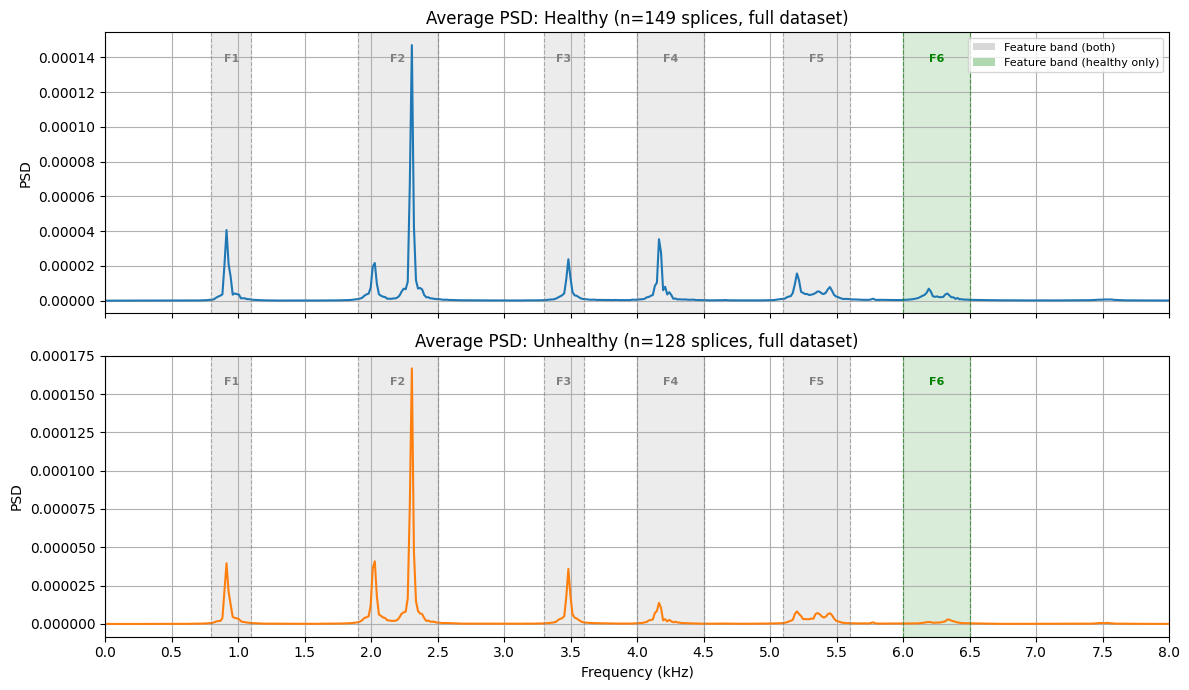

Train - healthy: 104, unhealthy: 89, total: 193
Test  - healthy: 45, unhealthy: 39, total: 84


In [ ]:
from scipy.signal import periodogram

# --- Average PSD on full dataset (before split) for feature identification ---
def peak_normalize(s):
    peak = np.max(np.abs(s))
    return s / peak if peak > 0 else s

f_h, _ = periodogram(peak_normalize(healthy_hits[0]), fs=SR)
avg_psd_healthy   = np.mean([periodogram(peak_normalize(s), fs=SR)[1] for s in healthy_hits],   axis=0)
avg_psd_unhealthy = np.mean([periodogram(peak_normalize(s), fs=SR)[1] for s in unhealthy_hits], axis=0)

# Feature bands identified from full dataset
bands = [
    (0.8,  1.1,  "F1",  False),
    (1.9,  2.5,  "F2",  False),
    (3.3,  3.6,  "F3",  False),
    (4.0,  4.5,  "F4",  False),
    (5.1,  5.6,  "F5",  False),
    (6.0,  6.5,  "F6",  True),
]

def add_bands(axis):
    ylim = axis.get_ylim()
    for lo, hi, label, healthy_only in bands:
        color = "green" if healthy_only else "gray"
        axis.axvspan(lo, hi, alpha=0.15, color=color)
        axis.axvline(lo, color=color, linewidth=0.8, linestyle="--", alpha=0.6)
        axis.axvline(hi, color=color, linewidth=0.8, linestyle="--", alpha=0.6)
        axis.text((lo + hi) / 2, ylim[1] * 0.92, label,
                  ha="center", va="top", fontsize=8, color=color, fontweight="bold")

fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(f_h / 1000, avg_psd_healthy)
ax[0].set_title(f"Average PSD: Healthy (n={len(healthy_hits)} splices, full dataset)")
ax[0].set_ylabel("PSD")
ax[0].grid()
ax[0].set_xlim(0, 8)
add_bands(ax[0])

ax[1].plot(f_h / 1000, avg_psd_unhealthy, color="tab:orange")
ax[1].set_title(f"Average PSD: Unhealthy (n={len(unhealthy_hits)} splices, full dataset)")
ax[1].set_ylabel("PSD")
ax[1].set_xlabel("Frequency (kHz)")
ax[1].grid()
ax[1].set_xlim(0, 8)
add_bands(ax[1])

ax[1].xaxis.set_major_locator(plt.MultipleLocator(0.5))

from matplotlib.patches import Patch
ax[0].legend(handles=[
    Patch(facecolor="gray",  alpha=0.3, label="Feature band (both)"),
    Patch(facecolor="green", alpha=0.3, label="Feature band (healthy only)"),
], fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

# --- Train / test split (after feature identification) ---
split = 0.7

train_healthy   = healthy_hits[:int(split * len(healthy_hits))]
test_healthy    = healthy_hits[int(split * len(healthy_hits)):]

train_unhealthy = unhealthy_hits[:int(split * len(unhealthy_hits))]
test_unhealthy  = unhealthy_hits[int(split * len(unhealthy_hits)):]

X_train = np.concatenate([train_healthy, train_unhealthy], axis=0)
y_train = np.array([0] * len(train_healthy) + [1] * len(train_unhealthy))

X_test = np.concatenate([test_healthy, test_unhealthy], axis=0)
y_test = np.array([0] * len(test_healthy) + [1] * len(test_unhealthy))

print(f"Train - healthy: {len(train_healthy)}, unhealthy: {len(train_unhealthy)}, total: {len(X_train)}")
print(f"Test  - healthy: {len(test_healthy)}, unhealthy: {len(test_unhealthy)}, total: {len(X_test)}")


## 5. Feature Extraction
Extract two feature sets from each splice:
- **MFCC** — 13 coefficients × (mean + std) = 26 features
- **PSD Band Energies** — total power in 6 identified frequency bands (F1–F6)

In [ ]:
# Feature Extraction — MFCC and PSD band energies
N_MFCC = 13

def extract_mfcc(splices, sr, n_mfcc=N_MFCC):
    features = []
    for splice in splices:
        mfcc = librosa.feature.mfcc(y=splice, sr=sr, n_mfcc=n_mfcc)
        features.append(np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)]))
    return np.array(features)

# PSD band energy features using the identified frequency bands
bands_hz = [
    (800,  1100),   # F1
    (1900, 2500),   # F2
    (3300, 3600),   # F3
    (4000, 4500),   # F4
    (5100, 5600),   # F5
    (6000, 6500),   # F6 - healthy only
]

def extract_psd_bands(splices, sr):
    features = []
    for splice in splices:
        f, Pxx = periodogram(splice, fs=sr)
        band_energies = [np.sum(Pxx[(f >= lo) & (f <= hi)]) for lo, hi in bands_hz]
        features.append(band_energies)
    return np.array(features)

X_train_mfcc = extract_mfcc(X_train, SR)
X_test_mfcc  = extract_mfcc(X_test,  SR)

X_train_psd  = extract_psd_bands(X_train, SR)
X_test_psd   = extract_psd_bands(X_test,  SR)

print(f"MFCC features — train: {X_train_mfcc.shape}, test: {X_test_mfcc.shape}")
print(f"PSD features  — train: {X_train_psd.shape},  test: {X_test_psd.shape}")


MFCC features — train: (193, 26), test: (84, 26)
PSD features  — train: (193, 6),  test: (84, 6)


## 6. K-Nearest Neighbours Classifier
Train KNN for k = 1, 3, 5, 10 using both feature sets and compare confusion matrices.

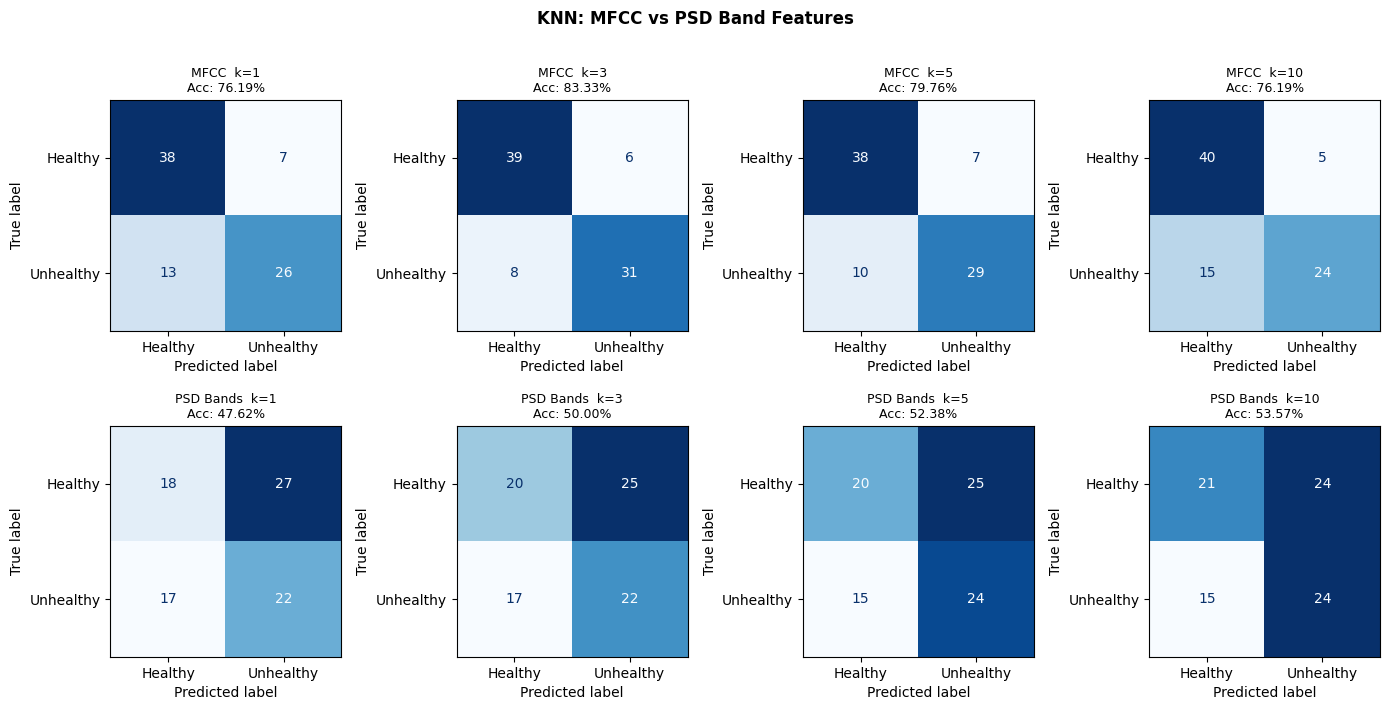

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

k_values = [1, 3, 5, 10]
feature_sets = [
    ("MFCC", X_train_mfcc, X_test_mfcc),
    ("PSD Bands", X_train_psd, X_test_psd),
]

fig, axes = plt.subplots(len(feature_sets), len(k_values), figsize=(14, 7))

for row, (feat_name, X_tr, X_te) in enumerate(feature_sets):
    for col, k in enumerate(k_values):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_train)
        y_pred = knn.predict(X_te)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Unhealthy"])
        disp.plot(ax=axes[row, col], cmap="Blues", colorbar=False)
        axes[row, col].set_title(f"{feat_name}  k={k}\nAcc: {acc:.2%}", fontsize=9)

plt.suptitle("KNN: MFCC vs PSD Band Features", fontsize=12, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()


## 7. Decision Tree Classifier
Train a decision tree on both feature sets, compare confusion matrices, and visualise the tree structure.

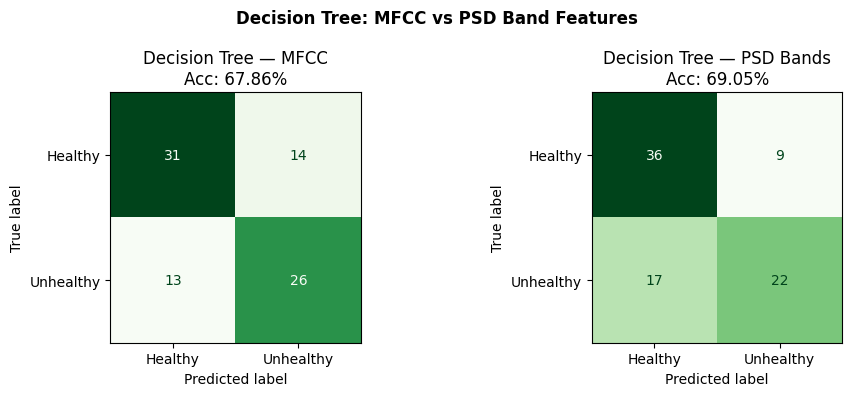

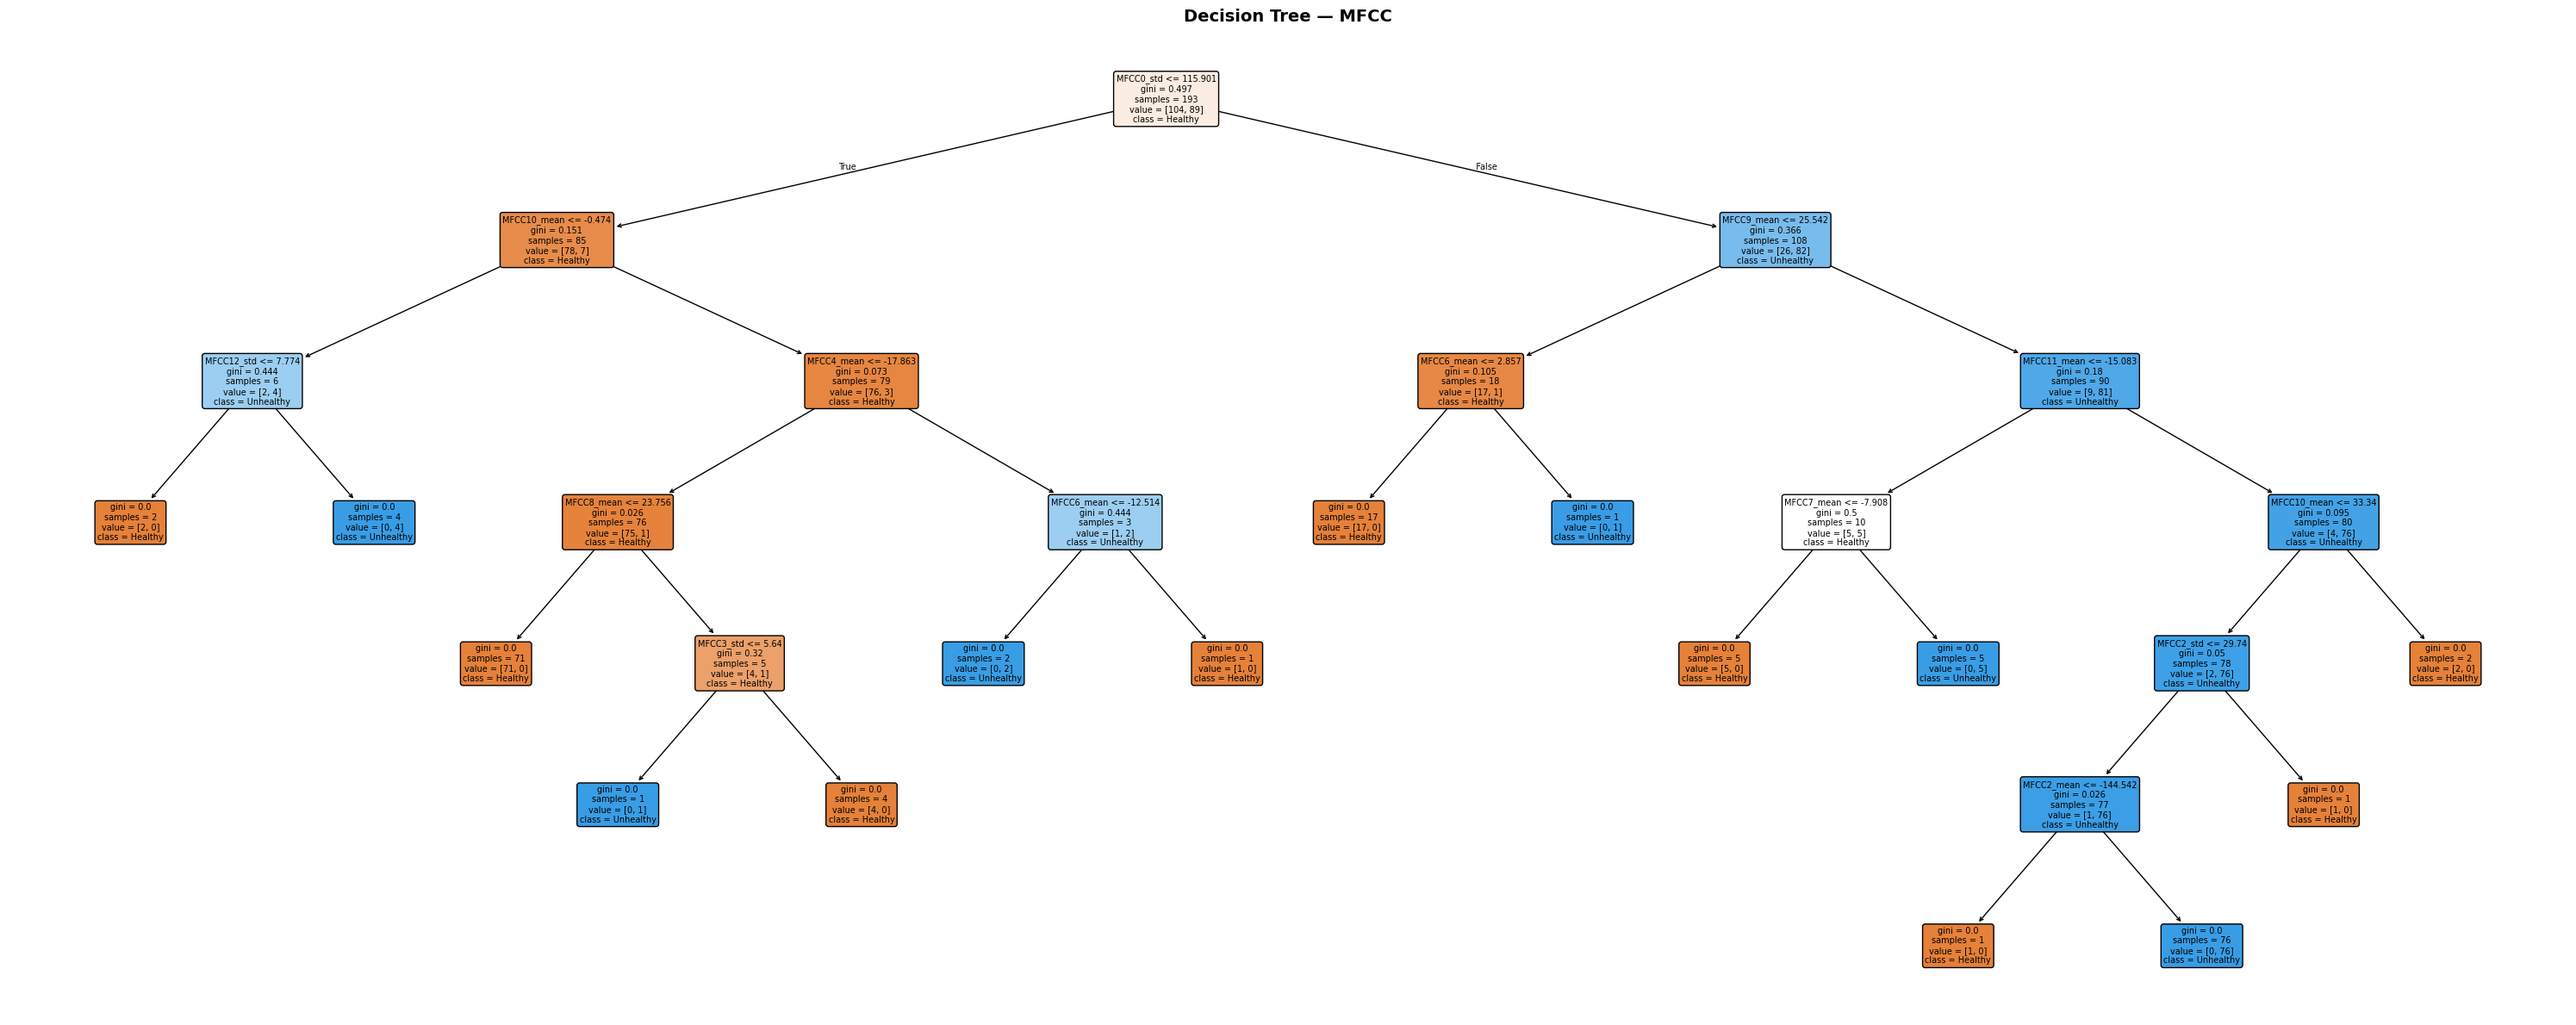

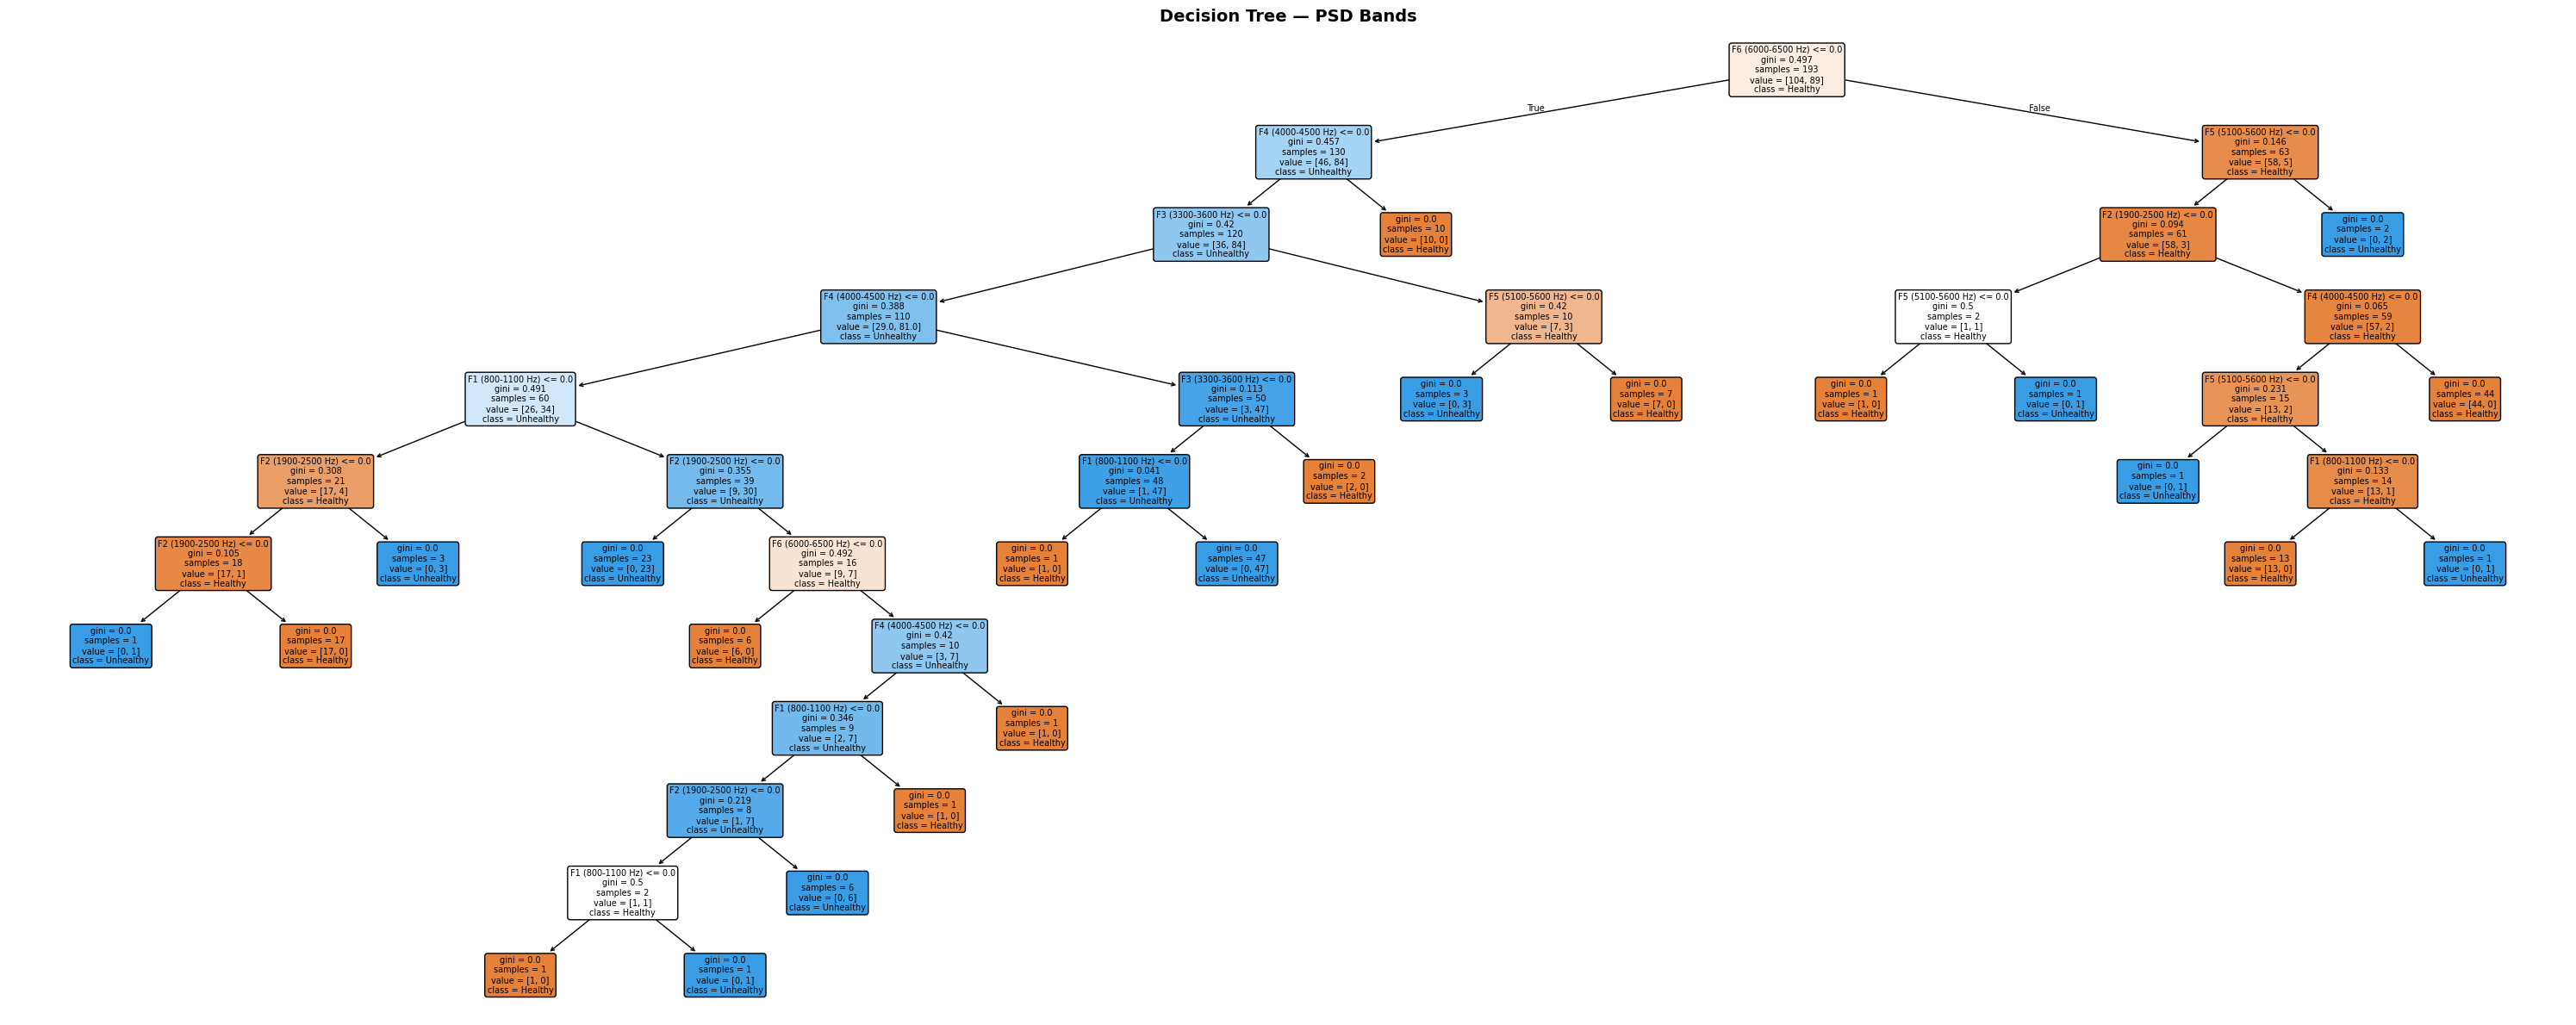

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

feature_sets = [
    ("MFCC", X_train_mfcc, X_test_mfcc),
    ("PSD Bands", X_train_psd, X_test_psd),
]

# Confusion matrices
fig, axes = plt.subplots(1, len(feature_sets), figsize=(10, 4))
trained_trees = {}

for ax, (feat_name, X_tr, X_te) in zip(axes, feature_sets):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_tr, y_train)
    trained_trees[feat_name] = (dt, X_tr)
    y_pred = dt.predict(X_te)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Unhealthy"])
    disp.plot(ax=ax, cmap="Greens", colorbar=False)
    ax.set_title(f"Decision Tree — {feat_name}\nAcc: {acc:.2%}")

plt.suptitle("Decision Tree: MFCC vs PSD Band Features", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# Tree diagrams
mfcc_feature_names = (
    [f"MFCC{i}_mean" for i in range(N_MFCC)] +
    [f"MFCC{i}_std"  for i in range(N_MFCC)]
)
psd_feature_names = [f"F{i+1} ({lo}-{hi} Hz)"
                     for i, (lo, hi) in enumerate(bands_hz)]

feature_names_map = {
    "MFCC":      mfcc_feature_names,
    "PSD Bands": psd_feature_names,
}

for feat_name, (dt, _) in trained_trees.items():
    fig, ax = plt.subplots(figsize=(30, 12))
    plot_tree(dt, feature_names=feature_names_map[feat_name],
              class_names=["Healthy", "Unhealthy"],
              filled=True, rounded=True, fontsize=7, ax=ax,
              )
    ax.set_title(f"Decision Tree — {feat_name}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()
